# Leemos el CSV

In [51]:
import pandas as pd

In [52]:
#2019
data19 = pd.read_csv('../csv/APARCAMIENTOS-DICIEMBRE-2019.csv')
#2022
data22 = pd.read_csv('../csv/APARCAMIENTOS-DICIEMBRE-2022.csv')

# Normalizacion de datos

In [53]:
#2019
LOCALIZATION = data19['LOCALIZATION'].unique().tolist()
data19['LOCALIZATION'] = data19['LOCALIZATION'].replace(LOCALIZATION, list(range(len(LOCALIZATION))))
data19['HOLIDAY'] = data19['HOLIDAY'].astype(int)
data19['SCHOOLDAY'] = data19['SCHOOLDAY'].astype(int)

In [54]:
data19

,LOCALIZATION,DAY,MONTH,YEAR,WEEKDAY,SCHOOLDAY,HOLIDAY,HOUR,TEMPERATURE,HUMIDITY,CHECK IN,CHECK OUT
0,0,31,12,2019,1,0,0,23,17,27,2,3
1,0,31,12,2019,1,0,0,22,18,24,1,3
2,0,31,12,2019,1,0,0,21,17,45,10,8
3,0,31,12,2019,1,0,0,20,17,48,11,20
4,0,31,12,2019,1,0,0,19,18,59,14,44
...,...,...,...,...,...,...,...,...,...,...,...,...
4459,5,1,12,2019,6,1,0,4,19,83,0,10
4460,5,1,12,2019,6,1,0,3,20,78,1,23
4461,5,1,12,2019,6,1,0,2,20,78,1,22
4462,5,1,12,2019,6,1,0,1,20,83,8,25


In [55]:
#2022
LOCALIZATION = data22['LOCALIZATION'].unique().tolist()
data22['LOCALIZATION'] = data22['LOCALIZATION'].replace(LOCALIZATION, list(range(len(LOCALIZATION))))
data22['HOLIDAY'] = data22['HOLIDAY'].astype(int)
data22['SCHOOLDAY'] = data22['SCHOOLDAY'].astype(int)

In [56]:
data22

,LOCALIZATION,DAY,MONTH,YEAR,WEEKDAY,SCHOOLDAY,HOLIDAY,HOUR,TEMPERATURE,HUMIDITY,CHECK IN,CHECK OUT
0,0,31,12,2022,5,1,0,23,18,88,0,2
1,0,31,12,2022,5,1,0,22,18,88,0,1
2,0,31,12,2022,5,1,0,21,18,83,19,12
3,0,31,12,2022,5,1,0,20,19,78,25,31
4,0,31,12,2022,5,1,0,19,20,78,15,63
...,...,...,...,...,...,...,...,...,...,...,...,...
5203,6,1,12,2022,3,1,0,4,19,60,4,0
5204,6,1,12,2022,3,1,0,3,18,68,0,1
5205,6,1,12,2022,3,1,0,2,19,64,0,1
5206,6,1,12,2022,3,1,0,1,19,60,0,0


# Creacion de `train` y `test`

Criterios propuestos por Salvador:

* train = datos del 1-12-2019 al 20-12-2019
* test  = datos del 21-12-2019 al 31-12-2019

In [57]:
train = data19.loc[(data19['DAY'].isin(range(1,21)))]
test  = data19.loc[(data19['DAY'].isin(range(21,32)))]

## Dividimos en `X` e `Y`

In [58]:
trainX = train.drop(['CHECK IN', 'CHECK OUT'], axis=1)
trainY = train[['CHECK OUT','CHECK IN']]

In [59]:
testX = test.drop(['CHECK IN', 'CHECK OUT'], axis=1)
testY = test[['CHECK OUT','CHECK IN']]

In [60]:
data22X = data22.drop(['CHECK IN', 'CHECK OUT'], axis=1)
data22Y = data22[['CHECK OUT','CHECK IN']]

# Escalado de los datos

Solo escalamos los `X` ya que de esta manera mantenemos los `Y` normalizados.

In [61]:
from sklearn.preprocessing import MaxAbsScaler

#Escalamos los datos
scaler = MaxAbsScaler()
trainX[trainX.columns] = scaler.fit_transform(trainX)
testX[testX.columns] = scaler.fit_transform(testX)
data22X[data22X.columns] = scaler.fit_transform(data22X)

# Entrenamiento de los modelos

In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import numpy as np
import joblib

## Prediciendo las entradas

### Obtenemos los mejores pesos para entrenar 

Mejor resultado: 
MAE => 16.224305900174503 
Valores => [5, 'distance']


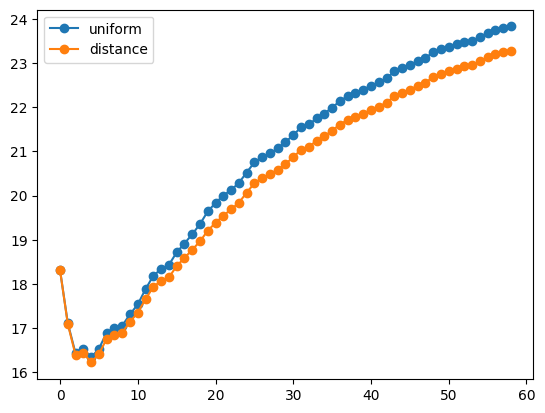

In [63]:
#Obtenmos lo que queremos predecir (ENTRADAS)
trainYe = trainY['CHECK IN']
testYe = testY['CHECK IN']

resE = {}
weights = ['uniform', 'distance']
uniform = []
distance = []
for K in range(1,60):
    for W in weights:
        knn = KNeighborsRegressor(K, weights=W)
        knn.fit(trainX, trainYe)
        predY = knn.predict(testX)
        scores = mae(testYe, predY)
        resE[str(scores)] = [K, W]
        #Obtenemos los resultados
        if W == 'uniform':
            uniform.append(scores)

        if W == 'distance':
            distance.append(scores)


print(f'Mejor resultado: \nMAE => {min(resE)} \nValores => {resE[min(resE)]}')

#Mostramos los resultados obtenidos
plt.plot(uniform, label='uniform', marker="o")
plt.plot(distance, label='distance', marker="o")
plt.legend()
plt.show()

### Entrenamos el modelo con los mejores parametros

Este entrenamiento lo hare con el dataframe al completo, de esta forma tendre los maximos datos para la fase de entrenamiento

In [64]:
#Preparamos los datos del dataframe completo
entradasX = data19.drop(['CHECK IN', 'CHECK OUT'], axis=1)
entradasX[entradasX.columns] = scaler.fit_transform(entradasX)

entradasY = data19['CHECK IN']

entradasknn = KNeighborsRegressor(resE[min(resE)][0], weights=resE[min(resE)][1])
entradasknn.fit(entradasX, entradasY)

KNeighborsRegressor(weights='distance')

### Hacemos una predicion sobre los datos de Diciembre 2022

In [65]:
#Dividimos los datos
data22eX = data22X
data22eY = data22['CHECK IN']

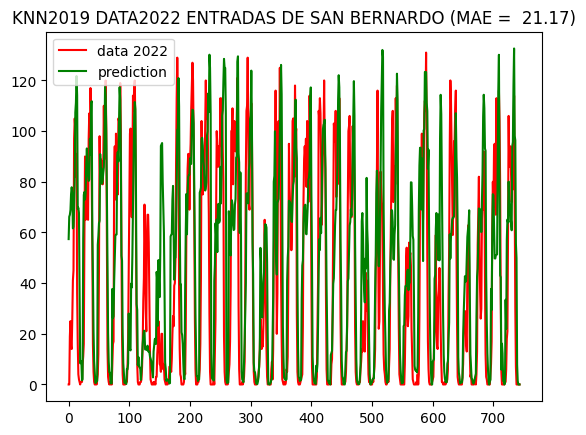

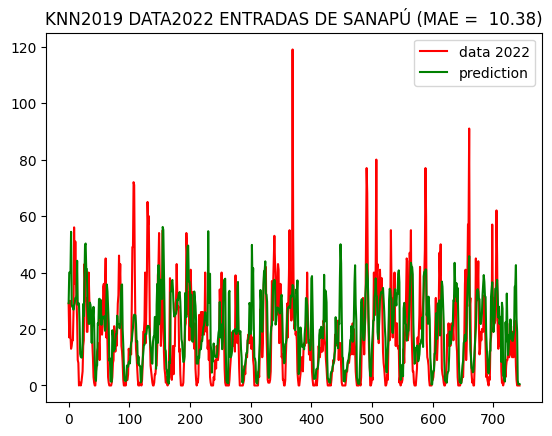

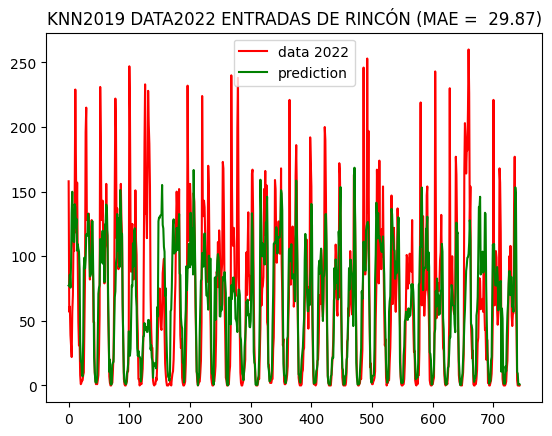

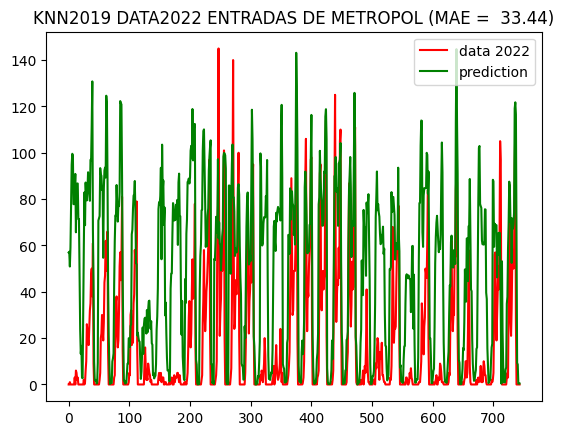

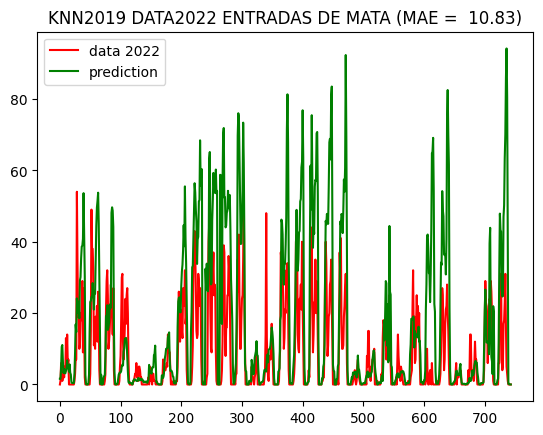

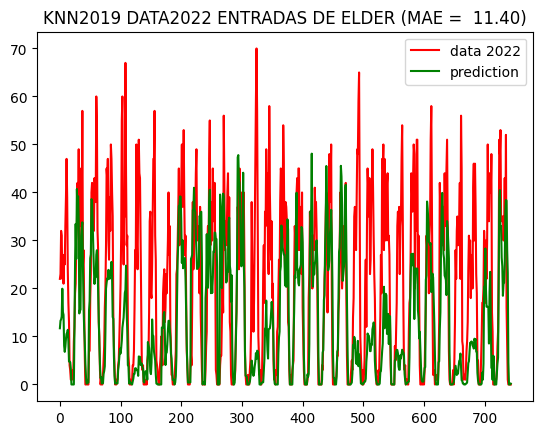

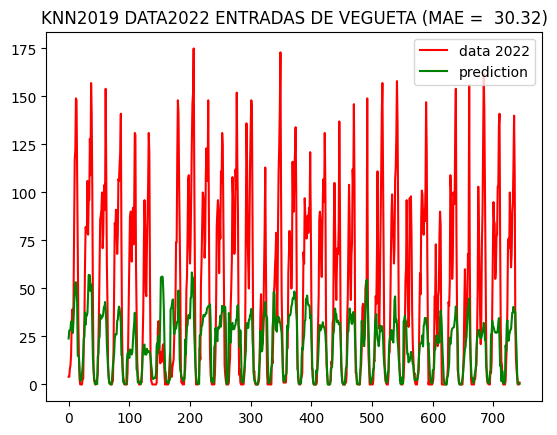

In [66]:
for pos,i in enumerate(data22eX['LOCALIZATION'].unique()):

    #Obtenemos los datos por localization
    index = data22eX.loc[data22eX['LOCALIZATION']==i].index.tolist()
    data22elX = data22eX.iloc[index]
    data22elY = data22eY.iloc[index]

    #Hacemos el predict y calculamos el mae
    predY = entradasknn.predict(data22elX)
    score = mae(data22elY, predY)

    #Mostarmos de forma grafica la diferencia entre el testY y predY
    xx = np.stack([i for i in range(data22elY.shape[0])])
    plt.plot(xx, data22elY, c='r', label='data 2022')
    plt.plot(xx, predY, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title(f'KNN2019 DATA2022 ENTRADAS DE {LOCALIZATION[int(pos)]} (MAE = %6.2f)' % (score))

    plt.show()

### Exportamos el modelo

In [67]:
joblib.dump(entradasknn,'../models/KNNentradas.pkl')

['../models/KNNentradas.pkl']

## Prediciendo las salidas

### Obtenemos los mejores pesos para entrenar 

Mejor resultado: 
MAE => 14.397206097303894 
Valores => [5, 'distance']


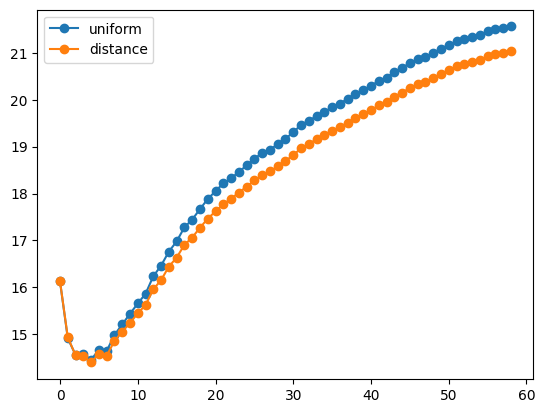

In [68]:
#Obtenmos lo que queremos predecir (SALIDAS)
trainYs = trainY['CHECK OUT']
testYs = testY['CHECK OUT']

resS = {}
weights = ['uniform', 'distance']
uniform = []
distance = []
for K in range(1,60):
    for W in weights:
        knn = KNeighborsRegressor(K, weights=W)
        knn.fit(trainX, trainYs)
        predY = knn.predict(testX)
        scores = mae(testYs, predY)
        resS[str(scores)] = [K, W]
        #Obtenemos los resultados
        if W == 'uniform':
            uniform.append(scores)

        if W == 'distance':
            distance.append(scores)


print(f'Mejor resultado: \nMAE => {min(resS)} \nValores => {resS[min(resS)]}')

#Mostramos los resultados obtenidos
plt.plot(uniform, label='uniform', marker="o")
plt.plot(distance, label='distance', marker="o")
plt.legend()
plt.show()

### Entrenamos el modelo con los mejores parametros

Este entrenamiento lo hare con el dataframe al completo, de esta forma tendre los maximos datos para la fase de entrenamiento

In [69]:
#Preparamos los datos del dataframe completo
salidasX = data19.drop(['CHECK IN', 'CHECK OUT'], axis=1)
salidasX[salidasX.columns] = scaler.fit_transform(salidasX)
salidasY = data19['CHECK IN']

salidasknn = KNeighborsRegressor(resE[min(resE)][0], weights=resE[min(resE)][1])
salidasknn.fit(salidasX, salidasY)

KNeighborsRegressor(weights='distance')

### Hacemos una predicion sobre los datos de Diciembre 2022

In [70]:
# dividimos los datos
data22sX = data22X
data22sY = data22['CHECK IN']

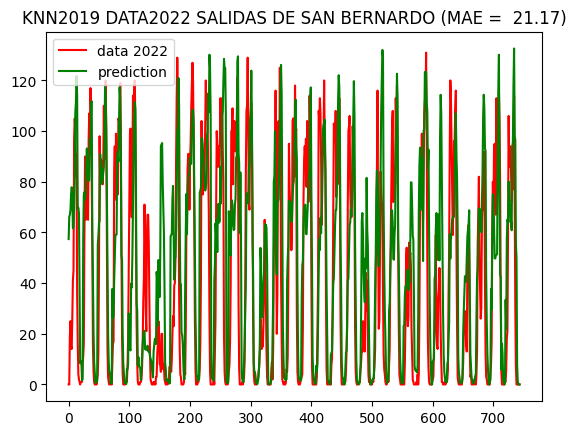

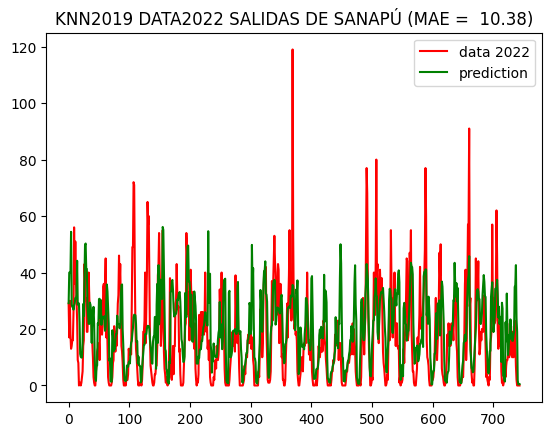

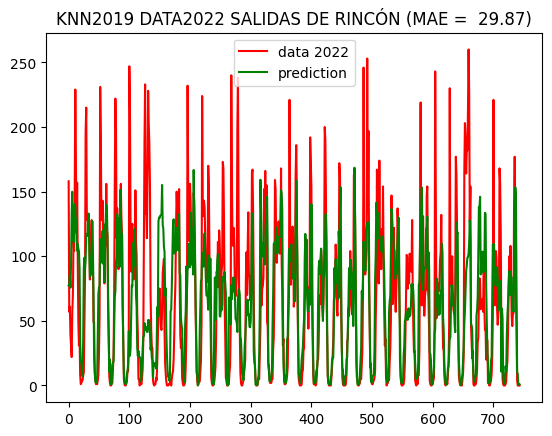

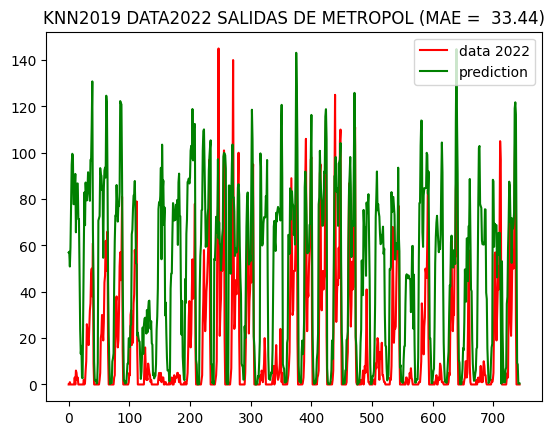

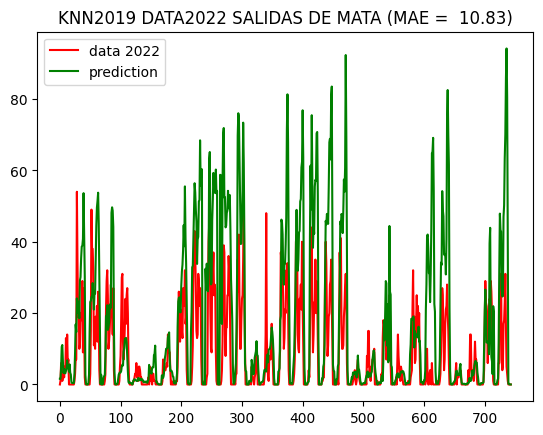

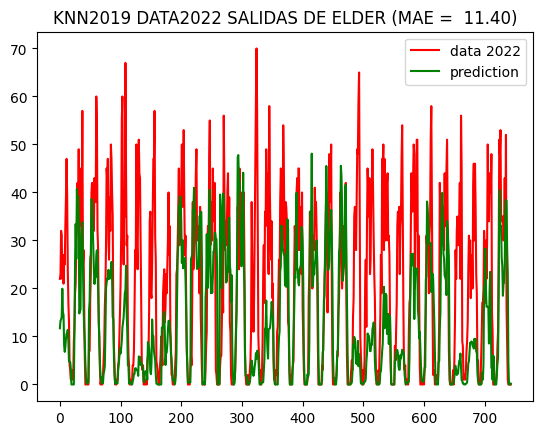

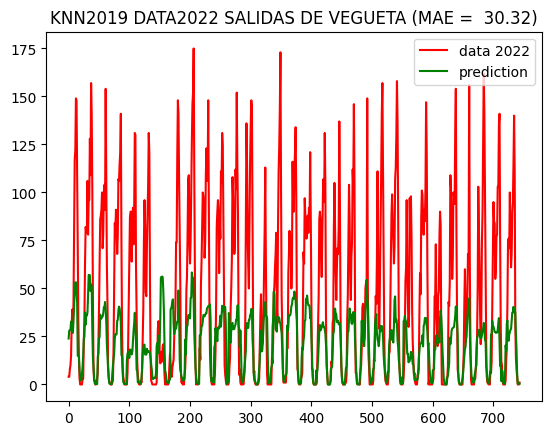

In [71]:
for pos,i in enumerate(data22sX['LOCALIZATION'].unique()):

    #Obtenemos los datos por localization
    index = data22sX.loc[data22sX['LOCALIZATION']==i].index.tolist()
    data22slX = data22sX.iloc[index]
    data22slY = data22sY.iloc[index]

    #Hacemos el predict y calculamos el mae
    predY = salidasknn.predict(data22slX)
    score = mae(data22slY, predY)

    #Mostarmos de forma grafica la diferencia entre el testY y predY
    xx = np.stack([i for i in range(data22slY.shape[0])])
    plt.plot(xx, data22slY, c='r', label='data 2022')
    plt.plot(xx, predY, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title(f'KNN2019 DATA2022 SALIDAS DE {LOCALIZATION[int(pos)]} (MAE = %6.2f)' % (score))

    plt.show()

### Exportamos el modelo

In [72]:
joblib.dump(salidasknn,'../models/KNNsalidas.pkl')

['../models/KNNsalidas.pkl']